<a href="https://colab.research.google.com/github/luciafrgit/Prueba/blob/main/mu_digitos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST

In this code, it is trained a neural network to classify digits from the MNIST dataset using a dropout architecture to have a good generalization.

In [3]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Configure device (GPU if available))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define data transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Define the DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Some information about this dataset:

- Images: Contains 70,000 grayscale images of handwritten digits
- Dimensions: Each image is 28x28 pixels in size.
- Tags: Each image is labeled with the corresponding digit (0-9).

In [5]:
# We define the Neural Network (we have improved it to have better results)

class ImprovedNN(nn.Module):
    def __init__(self):
        super(ImprovedNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

improved_model = ImprovedNN().to(device)

# Define the loss function and optimizer for the model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(improved_model.parameters(), lr=0.001)

# Training function
def train_model_dropout(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_accuracy = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_loss = running_loss / total
        train_accuracy = correct / total

        val_loss, val_accuracy = evaluate_model_with_loss(model, val_loader, criterion)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

    return train_losses, val_losses, train_accuracies, val_accuracies

# Function to evaluate the model with loss
def evaluate_model_with_loss(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss = running_loss / total
    accuracy = correct / total
    return loss, accuracy


In [7]:
# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model_dropout(improved_model, train_loader, test_loader, criterion, optimizer)

# Evaluate the model
improved_model.load_state_dict(torch.load('best_model.pth'))
test_loss, test_accuracy = evaluate_model_with_loss(improved_model, test_loader, criterion)
print(f'Initial Test Accuracy: {test_accuracy:.2f}%')

Epoch [1/5], Loss: 0.2114, Train Accuracy: 0.9352, Val Accuracy: 0.9658
Epoch [2/5], Loss: 0.2062, Train Accuracy: 0.9385, Val Accuracy: 0.9636
Epoch [3/5], Loss: 0.2008, Train Accuracy: 0.9403, Val Accuracy: 0.9696
Epoch [4/5], Loss: 0.1921, Train Accuracy: 0.9423, Val Accuracy: 0.9681
Epoch [5/5], Loss: 0.1854, Train Accuracy: 0.9440, Val Accuracy: 0.9721
Initial Test Accuracy: 0.97%


In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

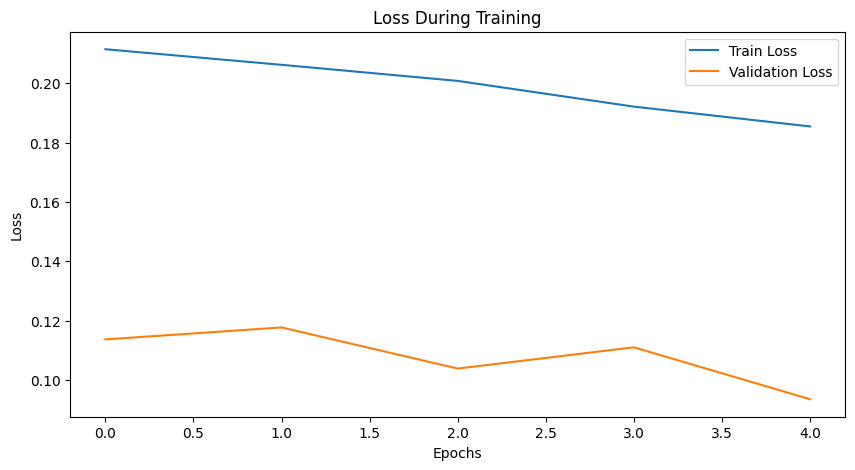

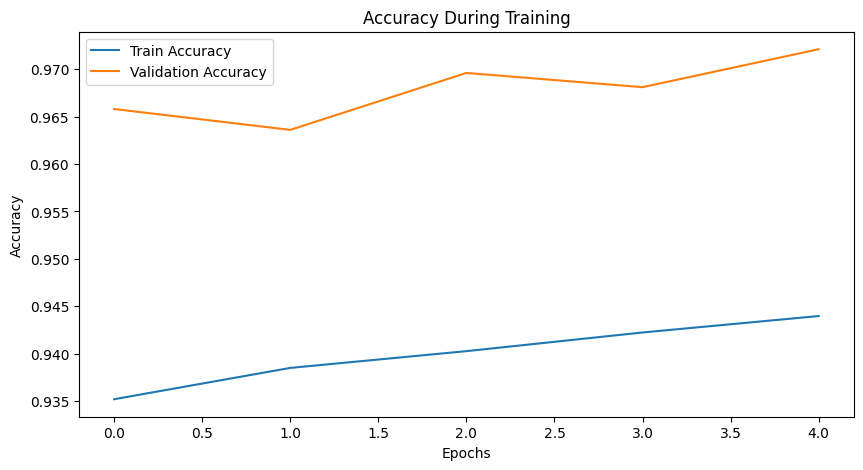

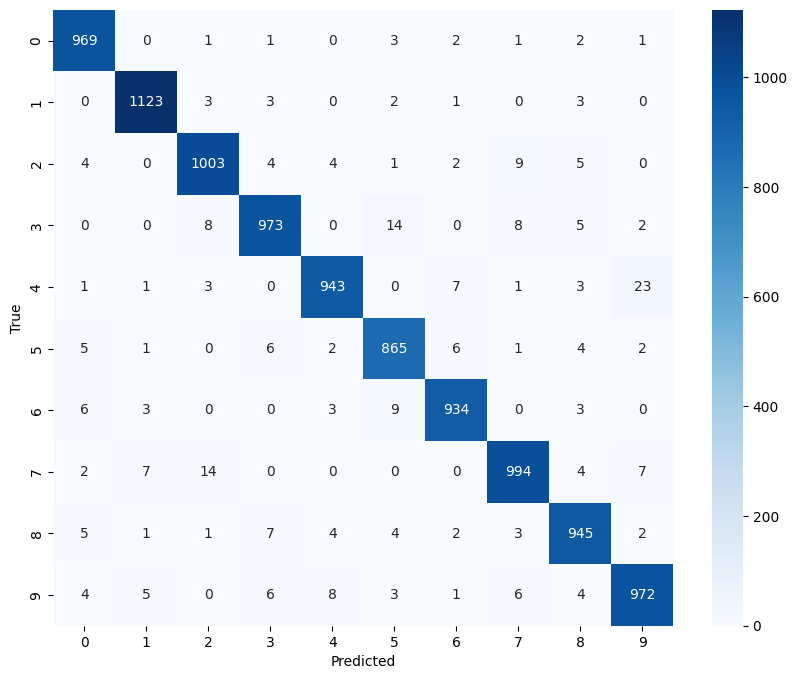

In [12]:
# Loss Graph
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss During Training')
plt.legend()
plt.show()

# Accuracy Graph
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy During Training')
plt.legend()
plt.show()

# Confusion Matrix
def plot_confusion_matrix(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(improved_model, test_loader)


# Machine Unlearning

We implement a process to "unlearn" the digit class '6', retraining the model to penalize this specific class. Moreover, we learn class '3'.

In [13]:
# Unlearn class '6'
class_weights = improved_model.fc3.weight.data
class_6_weights = class_weights[6].clone()

# Freeze all weights except those related to class '6'
for name, param in improved_model.named_parameters():
    if 'fc3.weight' in name:
        param.requires_grad = False
    elif param.shape[0] == 10:
        param.requires_grad = True

improved_model.fc3.weight.data[3] = class_6_weights.clone()

# Create the optimizer with only the parameters that are not frozen
optimizer = optim.Adam(filter(lambda p: p.requires_grad, improved_model.parameters()), lr=0.001)

# Define a new loss function that will favors class '3' and penalizes class '6'
def custom_loss_with_dropout(output, target):
    loss = criterion(output, target)
    penalty = torch.sum((output[:, 6]) ** 2)
    return loss + penalty


In [14]:
# Now we retrain the model to unlearn class '6' and learn class '3'
train_losses, val_losses, train_accuracies, val_accuracies = train_model_dropout(improved_model, train_loader, test_loader, custom_loss_with_dropout, optimizer)

# Evaluate the model
improved_model.load_state_dict(torch.load('best_model.pth'))
test_loss, final_accuracy = evaluate_model_with_loss(improved_model, test_loader, criterion)
print(f'Final Test Accuracy: {final_accuracy:.2f}%')


Epoch [1/5], Loss: 101.5157, Train Accuracy: 0.2659, Val Accuracy: 0.2928
Epoch [2/5], Loss: 2.9181, Train Accuracy: 0.2060, Val Accuracy: 0.3643
Epoch [3/5], Loss: 2.3262, Train Accuracy: 0.2592, Val Accuracy: 0.6201
Epoch [4/5], Loss: 2.1029, Train Accuracy: 0.3143, Val Accuracy: 0.6395
Epoch [5/5], Loss: 2.0166, Train Accuracy: 0.3386, Val Accuracy: 0.6843
Final Test Accuracy: 0.68%


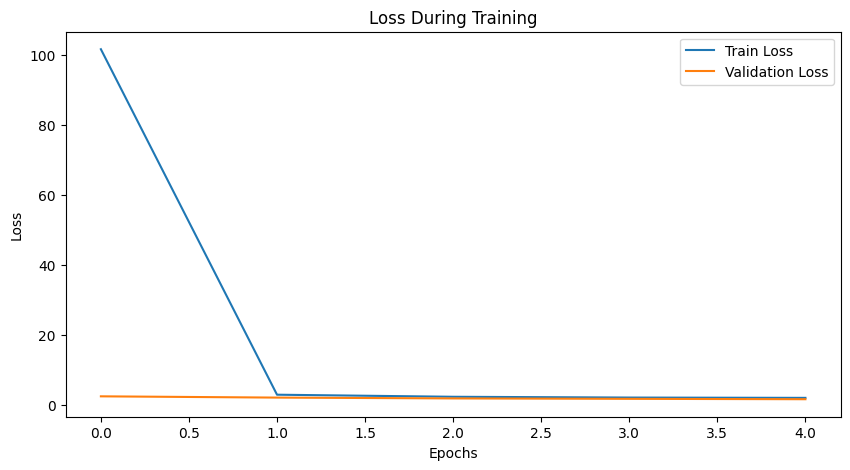

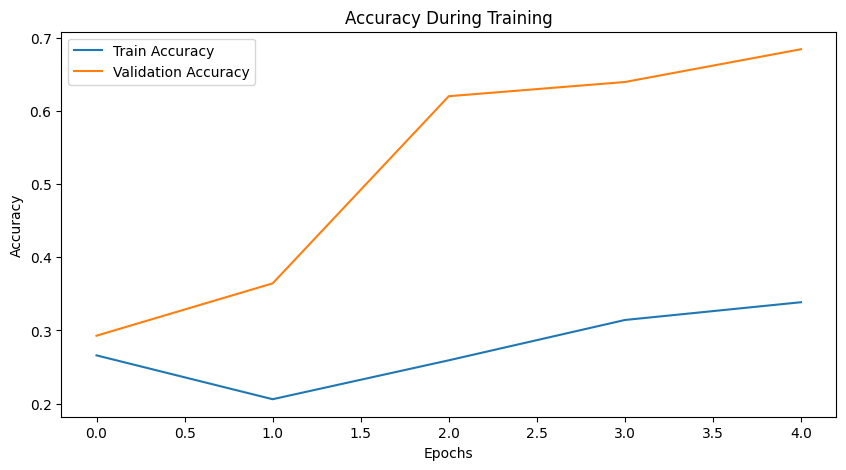

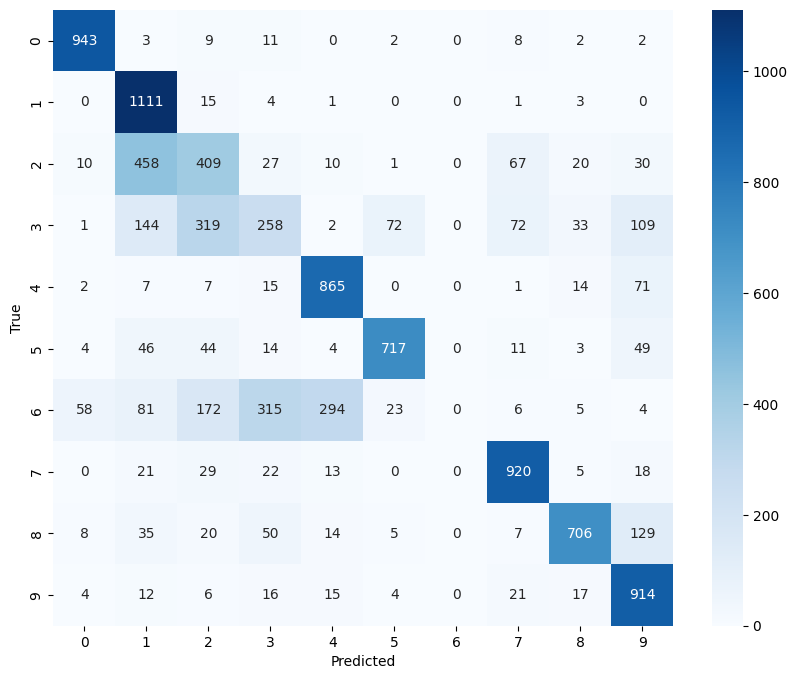

In [15]:
# Loss Graph
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss During Training')
plt.legend()
plt.show()

# Accuracy Graph
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy During Training')
plt.legend()
plt.show()

# Confusion Matrix
plot_confusion_matrix(improved_model, test_loader)